In [1]:
import glob
import scipy.ndimage
import sklearn.linear_model
import scipy.ndimage.filters

import numpy as np
import pylab as plt

import lemur_util

from lemur_pca import lemur_PCA
from lemur_soar import LemurSOAR


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)

N_IMAGES = 200
NEUTRAL_FACES_GLOB = 'faces/*a*'  # Select all the neutral faces
SMILING_FACES_GLOB = 'faces/*b*'  # Select all the smiling faces

N_TEST = 5
N_TRAINING = N_IMAGES - N_TEST
N_TRAINING_2 = 70
N_TEST_2 = N_IMAGES - 2*N_TRAINING_2

KAGGLE_FACES = 'faces.txt'
N_FEATURES = 3000


# Load neutral faces
neutral = []
for filename in sorted(glob.glob(NEUTRAL_FACES_GLOB)):
  neutral.append(scipy.ndimage.imread(filename, flatten=True).flatten() / 255)
neutral = np.array(neutral)

# Load smiling faces
smiling = []
for filename in sorted(glob.glob(SMILING_FACES_GLOB)):
  smiling.append(scipy.ndimage.imread(filename, flatten=True).flatten() / 255)
smiling = np.array(smiling)

V = lemur_PCA(KAGGLE_FACES, N_FEATURES, 2)

In [2]:
from lemur_soar import LemurSOAR

N_TEST = 5
N_TRAINING = N_IMAGES - N_TEST

# Shuffle images
p = np.random.permutation(smiling.shape[0])

neutral = neutral[p]
smiling = smiling[p]

neutral_pca = neutral.dot(V)
smiling_pca = smiling.dot(V)

neutral_training = neutral[:N_TRAINING]
smiling_training = smiling[:N_TRAINING]

neutral_training_pca = neutral_pca[:N_TRAINING]
smiling_training_pca = smiling_pca[:N_TRAINING]

neutral_test = neutral[N_TRAINING:]
smiling_test = smiling[N_TRAINING:]

neutral_test_pca = neutral_pca[N_TRAINING:]
smiling_test_pca = smiling_pca[N_TRAINING:]

neutral_training = np.append(neutral_training, smiling[:N_TRAINING], axis=0)
smiling_training = np.append(smiling_training, smiling[:N_TRAINING], axis=0)

neutral_training_pca = np.append(neutral_training_pca, smiling_pca[:N_TRAINING], axis=0)
smiling_training_pca = np.append(smiling_training_pca, smiling_pca[:N_TRAINING], axis=0)

neutral_training_2a = neutral_pca[:N_TRAINING_2]
neutral_training_2b = neutral_pca[N_TRAINING_2:2*N_TRAINING_2]

smiling_training_2a = smiling_pca[:N_TRAINING_2]
smiling_training_2b = smiling_pca[N_TRAINING_2:2*N_TRAINING_2]

neutral_test_2 = neutral_pca[2*N_TRAINING_2:]
smiling_test_2 = smiling_pca[2*N_TRAINING_2:]

neutral_training_2a = np.append(neutral_training_2a, smiling_training_2a, axis=0)
smiling_training_2a = np.append(smiling_training_2a, smiling_training_2a, axis=0)

neutral_training_2b = np.append(neutral_training_2b, smiling_training_2b, axis=0)
smiling_training_2b = np.append(smiling_training_2b, smiling_training_2b, axis=0)

In [51]:
class Lemur:
  def __init__(self, X, Y, r1=30, r2=1):
    X = np.append(X, np.ones(X.shape[0]).reshape(X.shape[0], 1), axis=1)
    n, d = X.shape
    X = X.T
    Y = Y.T
    I_d = np.eye(d-1)
    M = np.eye(n) + 1.0/r1 * X.T.dot(X) + 1.0/r2 * Y.T.dot(Y)
    U = np.zeros((d-1, d))
    V = np.zeros((d-1, d-1))
    for i in range(d-1):
      alpha = np.linalg.inv(M - np.outer(Y[i], Y[i])).dot(Y[i] - X[i])
      beta = -Y[i].dot(alpha)
      U[i] = 1.0/r1 * X.dot(alpha)
      V[i] = 1.0/r2 * Y.dot(alpha) + beta/r2 * I_d[i]
    W = V.T - I_d
    self.W = (U.T + np.eye(d, d-1)).dot(-W.T).dot(np.linalg.inv(W.dot(W.T)))
  def predict(self, X):
    X = np.append(X, np.ones(X.shape[0]).reshape(X.shape[0], 1), axis=1)
    return X.dot(self.W)
  
lemur = Lemur(neutral_training_pca, smiling_training_pca)

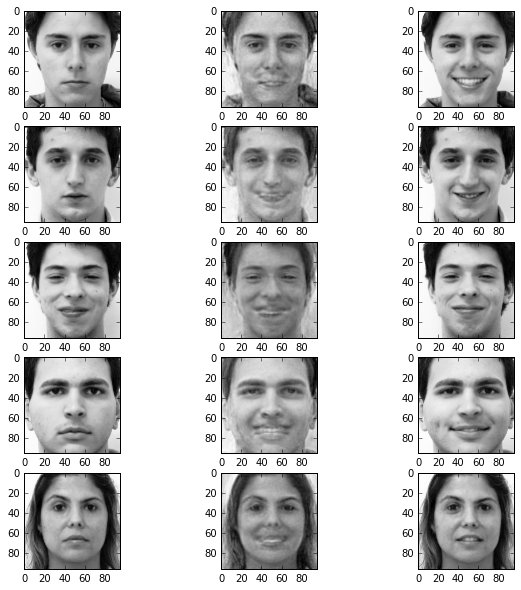

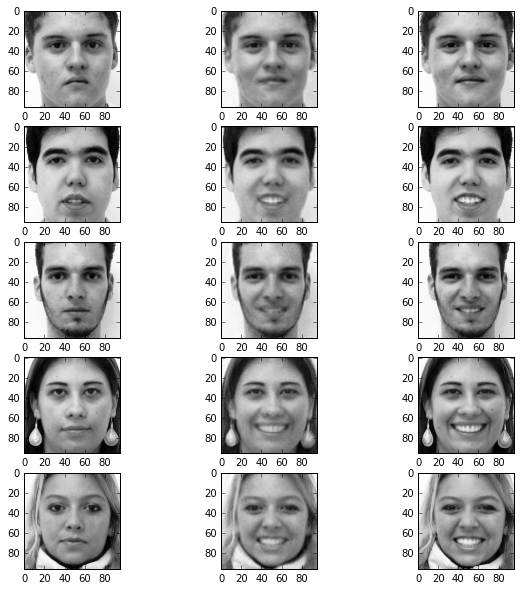

In [52]:
predictions = lemur.predict(neutral_test_pca).dot(V.T)
lemur_util.plot_predictions(neutral_test, predictions, smiling_test)
predictions = lemur.predict(neutral_training_pca[:N_TEST]).dot(V.T)
lemur_util.plot_predictions(neutral_training[:N_TEST], predictions, smiling_training[:N_TEST])